In [109]:
#ライブラリのインポート

# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd
import sklearn

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline



# 少数第３位まで表示
%precision 3

#データ分割（訓練データとテストデータ）のためのインポート
from sklearn.model_selection import train_test_split
# 単回帰のモデル構築のためのインポート
from sklearn.linear_model import LinearRegression
# ロジスティクス回帰モデルの構築のためのインポート
from sklearn.linear_model import LogisticRegression

# データの作成

In [110]:
#データを整形
weather = pd.read_csv('weather_info.csv' , engine='python')
weather_renew = weather[weather['Times of Day'] == 19]
weather_about = weather_renew[['date','pressure_state','temperature','Humidity','wind_speed']]
lot = pd.read_csv('result.csv' , engine='python')
lot_wed = pd.merge(weather_about, lot, on='date')
lot_wed_new = lot_wed[['pressure_state','temperature','Humidity','wind_speed','Winning_number']]
win_list = []
for i in range(len(lot_wed_new)):
    lot_wed_sub = lambda x: str(int(lot_wed_new.iloc[x,4])) if int(lot_wed_new.iloc[x,4]) >= 100 else str(int(lot_wed_new.iloc[x,4])).zfill(3)
    x = [int(a) for a in lot_wed_sub(i)]
    win_list.append(x)
    
win_df = pd.DataFrame(win_list,
                  columns=['win_first', 'win_second', 'win_third'])
lot_wed_df = lot_wed_new.join(win_df)
lot_wed_df = lot_wed_df[['pressure_state','temperature','Humidity','wind_speed','win_first', 'win_second', 'win_third']]
lot_wed_df.head()

,pressure_state,temperature,Humidity,wind_speed,win_first,win_second,win_third
0,1008.7,9.2,64,1.0,7,4,8
1,1013.0,12.2,51,1.1,9,8,8
2,1012.6,9.2,66,2.3,2,7,4
3,1011.2,8.8,33,5.2,6,0,3
4,1009.0,7.1,50,1.2,7,9,7


In [111]:
print('データの形式：{}'.format(lot_wed_df.shape))
print('データの型の確認:\n{}'.format(lot_wed_df.dtypes))

データの形式：(730, 7)
データの型の確認:
pressure_state    float64
temperature       float64
Humidity            int64
wind_speed        float64
win_first           int64
win_second          int64
win_third           int64
dtype: object


# 相関係数の出力と可視化

In [112]:
lot_wed_df.corr()

,pressure_state,temperature,Humidity,wind_speed,win_first,win_second,win_third
pressure_state,1.000000,-0.393413,-0.261992,-0.149721,0.056066,-0.038140,0.069471
temperature,-0.393413,1.000000,0.395045,0.209858,-0.008418,-0.020411,-0.057549
Humidity,-0.261992,0.395045,1.000000,-0.213355,-0.031690,0.000953,-0.008412
wind_speed,-0.149721,0.209858,-0.213355,1.000000,-0.060872,0.038824,-0.039738
win_first,0.056066,-0.008418,-0.031690,-0.060872,1.000000,-0.024238,0.022283
win_second,-0.038140,-0.020411,0.000953,0.038824,-0.024238,1.000000,-0.003093
win_third,0.069471,-0.057549,-0.008412,-0.039738,0.022283,-0.003093,1.000000


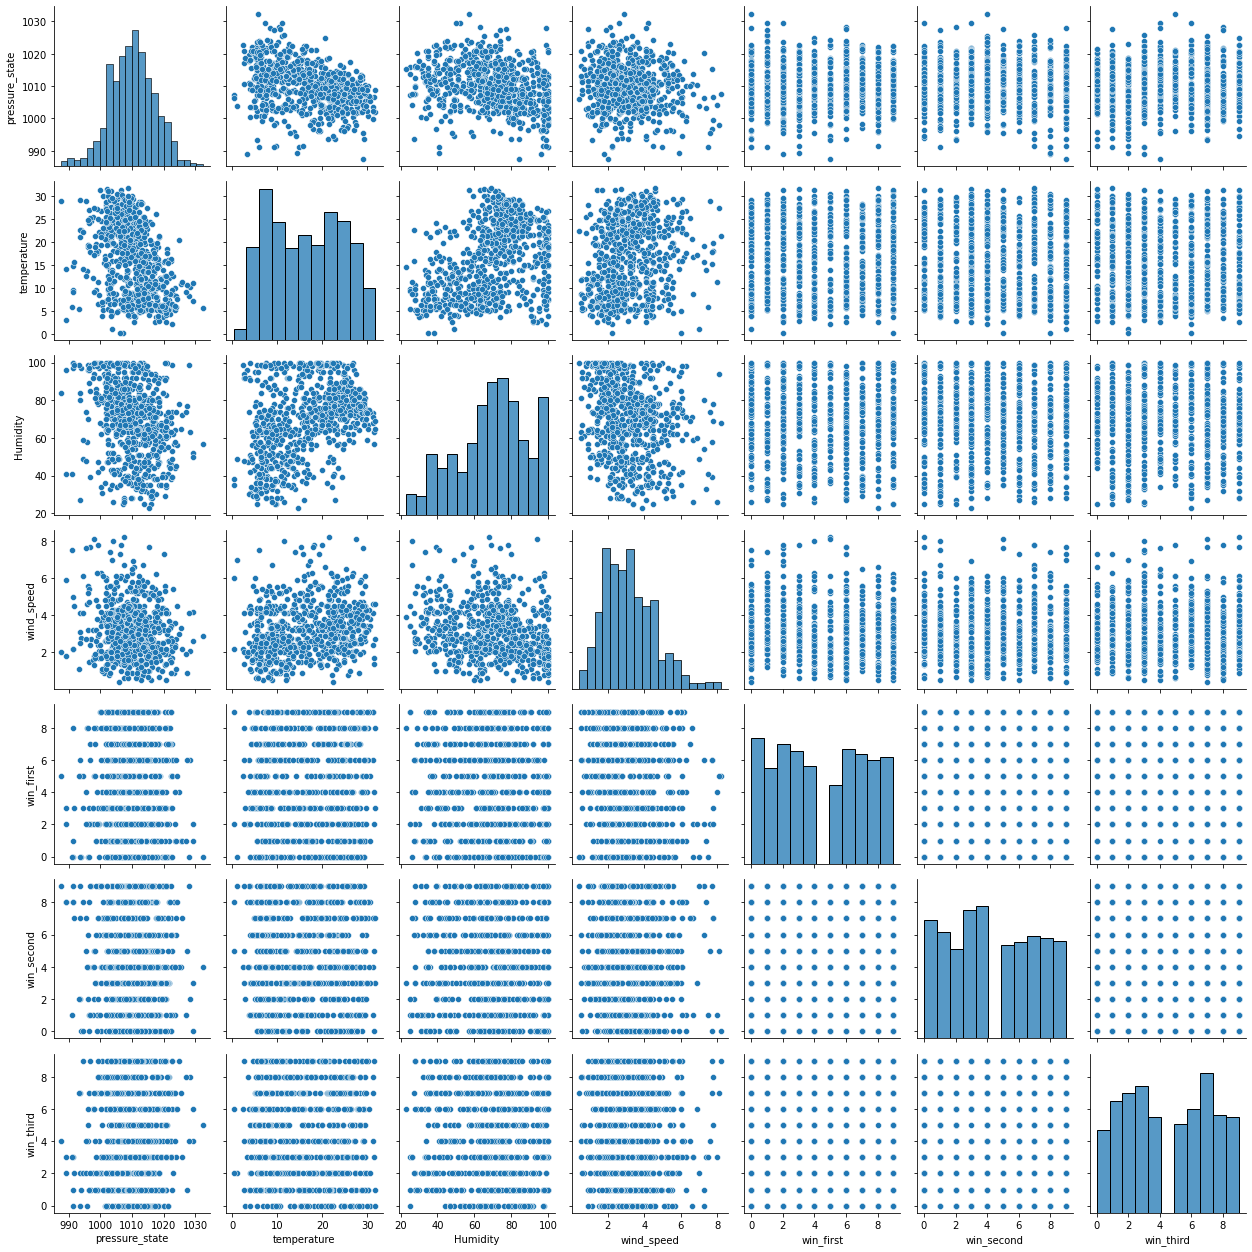

In [113]:
sns.pairplot(lot_wed_df)
plt.tight_layout()
plt.show()

# 単回帰モデル
### 今回は相関係数が１番大きかった、大気圧と３桁目の数字(1の位の数)との単回帰モデルを考える

In [114]:
#データの作成
lot_third = lot_wed_df[['pressure_state','win_third']]

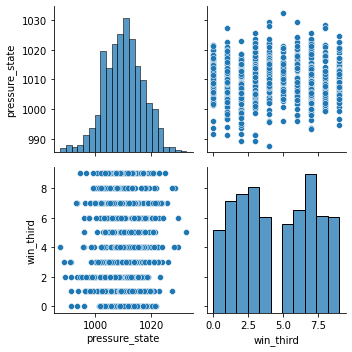

In [115]:
#相関係数について
sns.pairplot(lot_third)
plt.tight_layout()
plt.show()

In [116]:
#目的変数にwin_thirdを指定、説明変数にそれ以外を指定
X = lot_third.drop(['win_third'], axis = 1)
y = lot_third['win_third']

#訓練データとテストデータに分ける
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 0)

 #単回帰クラスの初期化と学習
model = LinearRegression()
model.fit(X_train,y_train)

# 決定係数を表示
print('決定係数(train):{:.3f}'.format(model.score(X_train, y_train)))
print('決定係数(test):{:.3f}'.format(model.score(X_test,y_test)))
# 回帰係数と切片を表示
print('\n回帰係数\n{}'.format(pd.Series(model.coef_, index = X.columns)))
print('切片:{:.3f}'.format(model.intercept_))

決定係数(train):0.000
決定係数(test):-0.020

回帰係数
pressure_state    0.002966
dtype: float64
切片:1.731


### 決定係数
- 「線形回帰モデルの評価関数の一つで、回帰式のモデルが観測データにどれくらい当てはまるかを表す。」
- 引用元 https://atmarkit.itmedia.co.jp/ait/articles/2108/25/news033.html
- この数字の絶対値が１に近づくほどいいモデルだと言える(ただこの決定係数の取り方も複数の定義があり、負の値を取らないような場合もある
- 引用元 https://biolab.sakura.ne.jp/r2.html

### 回帰係数
- 単回帰モデルを作成した際できる直線の傾きと切片

In [117]:
#pltの際にDataframe型のオブジェクトを引数にできないので、リストにする
#(anacondaなどの環境が違う場合は入れれたりもする)
l_1d = X.values.tolist()

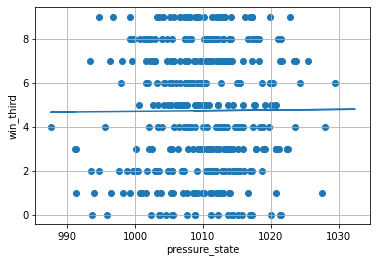

In [118]:
# 散布図を描画
plt.scatter(X_train, y_train)
plt.xlabel('pressure_state')
plt.ylabel('win_third')
# その上に線形回帰直線を引く
plt.plot(l_1d, model.predict(X))
plt.grid(True)

# ロジスティック回帰モデル
###  パラメータを['pressure_state','temperature','Humidity','wind_speed']として、３桁目(１の位)の数を推定するモデルを作りたい

In [119]:
#目的変数にwin_thirdを指定、説明変数にそれ以外を指定
X = lot_wed_df.drop(['win_first', 'win_second', 'win_third'], axis = 1)
y = lot_wed_df['win_third']

#訓練データとテストデータに分ける
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 0)

 # ロジスティック回帰クラスの初期化と学習
model = LogisticRegression()
model.fit(X_train,y_train)
print('決定係数(train):{:.3f}'.format(model.score(X_train,y_train)))
print('決定係数(test):{:.3f}'.format(model.score(X_test,y_test)))

決定係数(train):0.151
決定係数(test):0.107


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 何かしらのループにおいて収束があまりできていないとエラーが起こる
### 「原因は，LogisticRegressionの最大反復回数に達しなかったことにあるようです．つまり，途中で処理が打ち切られているという事です．この最大反復回数はmax_iterで設定できます．この値を設定しない場合は，デフォルト値である1000が適用されるようです．そのため，max_iterの値を1000より大きくすることで，警告文が消えると考えられます．」 
### 引用元　https://qiita.com/tatsu2015/items/8f01c89aa053e12e63b2

In [120]:
#目的変数にwin_thirdを指定、説明変数にそれ以外を指定
X = lot_wed_df.drop(['win_first', 'win_second', 'win_third'], axis = 1)
y = lot_wed_df['win_third']

#訓練データとテストデータに分ける
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 0)

 # ロジスティック回帰クラスの初期化と学習
model_Logistic = LogisticRegression(max_iter=1500)
model_Logistic.fit(X_train,y_train)
print('決定係数(train):{:.3f}'.format(model.score(X_train,y_train)))
print('決定係数(test):{:.3f}'.format(model.score(X_test,y_test)))

決定係数(train):0.151
決定係数(test):0.107


In [121]:
#分類した際のラベルの種類が幾つあるのかとりあえず出力してみる(プロパティ)
model.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# 実際にパラメータを入力して予測させてみる

### パラメータは['pressure_state','temperature','Humidity','wind_speed']
### 2022年3月10日の当選番号は920
### 2022年3月10日の気象データは[1017.9,12.3,43,2.6]

In [122]:
type(X_train)

pandas.core.frame.DataFrame

In [123]:
X_predict = [1017.9,12.3,43,2.6]
X_predict = pd.DataFrame(X_predict).T
X_predict.columns = ['pressure_state','temperature','Humidity','wind_speed']
X_predict

,pressure_state,temperature,Humidity,wind_speed
0,1017.9,12.3,43.0,2.6


In [124]:
model_Logistic.predict(X_predict)

array([2])

### 実際の３桁目の数字は０だけど、このモデルだと２が出ると予測している

# 同じことを1桁目、2桁目でもやってみる

In [126]:
#目的変数にwin_firstを指定、説明変数にそれ以外を指定
X_f = lot_wed_df.drop(['win_first', 'win_second', 'win_third'], axis = 1)
y_f = lot_wed_df['win_first']

#訓練データとテストデータに分ける
Xf_train,Xf_test,yf_train,yf_test = train_test_split(X_f,y_f,test_size = 0.5,random_state = 0)

 # ロジスティック回帰クラスの初期化と学習
model_Logistic = LogisticRegression(max_iter=1500)
model_Logistic.fit(Xf_train,yf_train)
print('決定係数(train):{:.3f}'.format(model.score(Xf_train,yf_train)))
print('決定係数(test):{:.3f}'.format(model.score(Xf_test,yf_test)))

決定係数(train):0.090
決定係数(test):0.134


In [127]:
model_Logistic.predict(X_predict)

array([6])

In [128]:
#目的変数にwin_secondを指定、説明変数にそれ以外を指定
X_s = lot_wed_df.drop(['win_first', 'win_second', 'win_third'], axis = 1)
y_s = lot_wed_df['win_second']

#訓練データとテストデータに分ける
Xs_train,Xs_test,ys_train,ys_test = train_test_split(X_s,y_s,test_size = 0.5,random_state = 0)

 # ロジスティック回帰クラスの初期化と学習
model_Logistic = LogisticRegression(max_iter=1500)
model_Logistic.fit(Xs_train,ys_train)
print('決定係数(train):{:.3f}'.format(model.score(Xs_train,ys_train)))
print('決定係数(test):{:.3f}'.format(model.score(Xs_test,ys_test)))

決定係数(train):0.093
決定係数(test):0.090


In [129]:
model_Logistic.predict(X_predict)

array([1])

### このモデルを使うと2022年3月10日の気象データを入れた場合、当選番号は「612」と出力された